## 01 - Carga, entendimiento y limpieza de datos

En este notebook se llevará a cabo la primera fase del análisis de datos, centrada en la carga, comprensión y limpieza del conjunto de datos. El objetivo de esta etapa es preparar los datos para el análisis posterior, asegurándonos de que la información esté limpia, coherente y lista para ser procesada.

El set de datros utilizado contiene el comportamiento histórico de los niveles de generación de energía eléctrica (medidos en megawatts/hora, o MWh) para diferentes fuentes de generación (petróleo, solar, térmica...) desde el 2001 hasta el 2024.

Estos datos están disponibles en el sitiom web de U.S. Energy Information Administration (EIA) (https://www.eia.gov/) y son datos reales que se actualzian constantemente.

### Estructura del archivo Excel

- El archivo contiene 19 hojas de cálculo, la última es información que no nos interesa.
- Las primeras 5 hojas tienen el encabezado en la fila 0, el resto en la fila 4
- Todas las hojas contienen las mismas columnas

Esto es clave para leer el archivo correctamente con Pandas

### Lectura del archivo

Para leer el se de datos y tenerlo en un solo Dataframe:

1. Leeremos cada hoja individualmente en un DataFrame de Pandas
2. Se almacenarán los dataFrames en una lista
3. Concatenaremos la lista anterior en un solo DataFrame

Vamos allá

In [1]:
import pandas as pd

Sheet_names = list(range(18))
Data = [None] * len(Sheet_names)

for i in Sheet_names:
    if i < 5:
        df = pd.read_excel("../data/generation_monthly.xlsx", sheet_name=i)
    else:
        df = pd.read_excel("../data/generation_monthly.xlsx", sheet_name=i, skiprows=4)
    
    # Limpiar nombres de columnas
    df.columns = df.columns.str.strip().str.replace('\n', ' ', regex=False)
    
    Data[i] = df

# Concatenar todos los DataFrames
df = pd.concat(Data, ignore_index=True)
print(df.columns)



Index(['YEAR', 'MONTH', 'STATE', 'TYPE OF PRODUCER', 'ENERGY SOURCE',
       'GENERATION (Megawatthours)'],
      dtype='object')


In [2]:
df.sample(5)

,YEAR,MONTH,STATE,TYPE OF PRODUCER,ENERGY SOURCE,GENERATION (Megawatthours)
433275,2019,12,AR,Total Electric Power Industry,Solar Thermal and Photovoltaic,11236.0
420414,2019,5,WI,"Electric Generators, Electric Utilities",Total,3625322.0
86399,2005,2,MD,"Electric Generators, Independent Power Producers",Other Biomass,13244.0
147871,2007,12,LA,"Combined Heat and Power, Industrial Power",Other Biomass,418.0
484161,2021,12,AR,"Electric Generators, Electric Utilities",Nuclear,1331532.0


In [27]:
df.shape

(562796, 7)

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 562796 entries, 0 to 562795
Data columns (total 7 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   YEAR                        562796 non-null  int64         
 1   MONTH                       562796 non-null  int64         
 2   STATE                       562796 non-null  object        
 3   TYPE OF PRODUCER            562796 non-null  object        
 4   ENERGY SOURCE               562796 non-null  object        
 5   GENERATION (Megawatthours)  562796 non-null  float64       
 6   DATE                        562796 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(2), object(3)
memory usage: 30.1+ MB


In [28]:
df.duplicated().sum()

0

### Planteamiento del Análisis

En este dataset tenemos varias series de tiempo, por lo que se peuden realziar múltiples análisis exploratorios, nosotros nos centraremos en el comportamiento histórico de las series a nivel de fuente de generación (Energy source)

---

### Preprocesamiento y limpieza

Comenzaremso convirtiendo el dataFrame a Series de tiempo, creando una columna Date con el aó y mes del registro, al no haber día, le asignaremos el primer día del mes:

In [3]:
df["DATE"] = pd.to_datetime(df[["YEAR", "MONTH"]].assign(DAY=1))
df.head()

,YEAR,MONTH,STATE,TYPE OF PRODUCER,ENERGY SOURCE,GENERATION (Megawatthours),DATE
0,2001,1,AK,Total Electric Power Industry,Coal,46903.0,2001-01-01
1,2001,1,AK,Total Electric Power Industry,Petroleum,71085.0,2001-01-01
2,2001,1,AK,Total Electric Power Industry,Natural Gas,367521.0,2001-01-01
3,2001,1,AK,Total Electric Power Industry,Hydroelectric Conventional,104549.0,2001-01-01
4,2001,1,AK,Total Electric Power Industry,Wind,87.0,2001-01-01


Ahora fijaremso esta nueva columna como el índice y eliminaremos las columnas year y month ya que no son necesarias. Tambien eliminaremos state y type of producer, ya que en este análisis solo nos centraremos en energy source:

In [4]:
df_energy = df.copy()
df_energy = df_energy.set_index("DATE")
df_energy = df_energy.drop(columns=["YEAR", "MONTH", "STATE", "TYPE OF PRODUCER"])
df_energy.head()

,ENERGY SOURCE,GENERATION (Megawatthours)
DATE,,
2001-01-01,Coal,46903.0
2001-01-01,Petroleum,71085.0
2001-01-01,Natural Gas,367521.0
2001-01-01,Hydroelectric Conventional,104549.0
2001-01-01,Wind,87.0


Veamos las categorias de Energy Source:

In [5]:
df_energy["ENERGY SOURCE"].value_counts()

ENERGY SOURCE
Total                             82387
Natural Gas                       74717
Petroleum                         70796
Coal                              52929
Other Biomass                     52221
Hydroelectric Conventional        43657
Other                             41673
Wood and Wood Derived Fuels       34494
Wind                              29583
Solar Thermal and Photovoltaic    25362
Other Gases                       20161
Nuclear                           18585
Pumped Storage                    11410
Geothermal                         4821
Name: count, dtype: int64

Cada una de estas fuentes de energía será una serie de tiempo, utilizaremos groupby para agruupar los datos por fuente y fecha y así las podremos analizar correctamente:

In [6]:
grupo = df_energy.groupby(["ENERGY SOURCE", df_energy.index]).sum()
grupo

GENERATION (Megawatthours)
ENERGY SOURCE               DATE                                  
Coal                        2001-01-01                 709148444.0
                            2001-02-01                 598941934.0
                            2001-03-01                 621076042.0
                            2001-04-01                 562682612.0
                            2001-05-01                 606371658.0
...                                                            ...
Wood and Wood Derived Fuels 2024-08-01                  11301330.0
                            2024-09-01                  10433405.0
                            2024-10-01                   9186748.0
                            2024-11-01                  10218310.0
                            2024-12-01                  10997871.0

[4032 rows x 1 columns]

Podríamos convertir ya a un dataframe con índice Fechas y columnas cada energy source así:

- df_pivot = grupo.unstack("ENERGY SOURCE")
- df_pivot.columns = df_pivot.columns.get_level_values(1)
- df_pivot.columns.name = None

Pero como no sabemos si hay nulos, antes nos interesa tener un DataFrame individual para cada serie de tiempo para poder limpiar cada una, extraeremos los nombres de cada fuente de energia y crearemos un dicionario con cada serie: 

In [7]:
nombres_series = grupo.index.get_level_values("ENERGY SOURCE").unique()
nombres_series

Index(['Coal', 'Geothermal', 'Hydroelectric Conventional', 'Natural Gas',
       'Nuclear', 'Other', 'Other Biomass', 'Other Gases', 'Petroleum',
       'Pumped Storage', 'Solar Thermal and Photovoltaic', 'Total', 'Wind',
       'Wood and Wood Derived Fuels'],
      dtype='object', name='ENERGY SOURCE')

In [8]:
series = {}

for nombre in nombres_series:
    if nombre != "Total": # Exluimos el Total ya que no nos interesa
        serie = grupo.xs(nombre, level="ENERGY SOURCE").sort_index()
        series[nombre] = serie

series

{'Coal':             GENERATION (Megawatthours)
 DATE                                  
 2001-01-01                 709148444.0
 2001-02-01                 598941934.0
 2001-03-01                 621076042.0
 2001-04-01                 562682612.0
 2001-05-01                 606371658.0
 ...                                ...
 2024-08-01                 275351840.0
 2024-09-01                 218512424.0
 2024-10-01                 187829342.0
 2024-11-01                 179978751.0
 2024-12-01                 251553874.0
 
 [288 rows x 1 columns],
 'Geothermal':             GENERATION (Megawatthours)
 DATE                                  
 2001-01-01                   4917300.0
 2001-02-01                   4292176.0
 2001-03-01                   4760092.0
 2001-04-01                   4379964.0
 2001-05-01                   4285520.0
 ...                                ...
 2024-08-01                   5273578.0
 2024-09-01                   5106659.0
 2024-10-01                   4

Comprobaremos el número de registros de cada serie y sus fechas de inicio y fin:

In [9]:
for key, value in series.items():
    print(f"Número de registros serie {key}: {len(series[key])}")
    print(f"Fecha inico y final serie {key}: {series[key].index.min()} {series[key].index.max()}")
    print("-"*100)

Número de registros serie Coal: 288
Fecha inico y final serie Coal: 2001-01-01 00:00:00 2024-12-01 00:00:00
----------------------------------------------------------------------------------------------------
Número de registros serie Geothermal: 288
Fecha inico y final serie Geothermal: 2001-01-01 00:00:00 2024-12-01 00:00:00
----------------------------------------------------------------------------------------------------
Número de registros serie Hydroelectric Conventional: 288
Fecha inico y final serie Hydroelectric Conventional: 2001-01-01 00:00:00 2024-12-01 00:00:00
----------------------------------------------------------------------------------------------------
Número de registros serie Natural Gas: 288
Fecha inico y final serie Natural Gas: 2001-01-01 00:00:00 2024-12-01 00:00:00
----------------------------------------------------------------------------------------------------
Número de registros serie Nuclear: 288
Fecha inico y final serie Nuclear: 2001-01-01 00:00:00 

Antes de continuar, veremos si existen datos o marcas de tiempo faltantes o marcas de tiempo "ocultas":

In [10]:
# Datos faltantes
for key, value in series.items():
    print(f"Nulos en {key}: {series[key].isna().sum()}")

Nulos en Coal: GENERATION (Megawatthours)    0
dtype: int64
Nulos en Geothermal: GENERATION (Megawatthours)    0
dtype: int64
Nulos en Hydroelectric Conventional: GENERATION (Megawatthours)    0
dtype: int64
Nulos en Natural Gas: GENERATION (Megawatthours)    0
dtype: int64
Nulos en Nuclear: GENERATION (Megawatthours)    0
dtype: int64
Nulos en Other: GENERATION (Megawatthours)    0
dtype: int64
Nulos en Other Biomass: GENERATION (Megawatthours)    0
dtype: int64
Nulos en Other Gases: GENERATION (Megawatthours)    0
dtype: int64
Nulos en Petroleum: GENERATION (Megawatthours)    0
dtype: int64
Nulos en Pumped Storage: GENERATION (Megawatthours)    0
dtype: int64
Nulos en Solar Thermal and Photovoltaic: GENERATION (Megawatthours)    0
dtype: int64
Nulos en Wind: GENERATION (Megawatthours)    0
dtype: int64
Nulos en Wood and Wood Derived Fuels: GENERATION (Megawatthours)    0
dtype: int64


In [11]:
# Marcas de tiempo faltantes
for key, value in series.items():
    print(f"Nulos en el índice de {key}: {series[key].index.isna().sum()}")

Nulos en el índice de Coal: 0
Nulos en el índice de Geothermal: 0
Nulos en el índice de Hydroelectric Conventional: 0
Nulos en el índice de Natural Gas: 0
Nulos en el índice de Nuclear: 0
Nulos en el índice de Other: 0
Nulos en el índice de Other Biomass: 0
Nulos en el índice de Other Gases: 0
Nulos en el índice de Petroleum: 0
Nulos en el índice de Pumped Storage: 0
Nulos en el índice de Solar Thermal and Photovoltaic: 0
Nulos en el índice de Wind: 0
Nulos en el índice de Wood and Wood Derived Fuels: 0


In [12]:
# Marcas de tiempo ocultas
for key, value in series.items():
    rango_fechas = pd.date_range(start= series[key].index.min(), end= series[key].index.max(), freq="MS")
    print(f"Marcas ocultas en {key}: {rango_fechas.difference(series[key].index)}")

Marcas ocultas en Coal: DatetimeIndex([], dtype='datetime64[ns]', freq='MS')
Marcas ocultas en Geothermal: DatetimeIndex([], dtype='datetime64[ns]', freq='MS')
Marcas ocultas en Hydroelectric Conventional: DatetimeIndex([], dtype='datetime64[ns]', freq='MS')
Marcas ocultas en Natural Gas: DatetimeIndex([], dtype='datetime64[ns]', freq='MS')
Marcas ocultas en Nuclear: DatetimeIndex([], dtype='datetime64[ns]', freq='MS')
Marcas ocultas en Other: DatetimeIndex([], dtype='datetime64[ns]', freq='MS')
Marcas ocultas en Other Biomass: DatetimeIndex([], dtype='datetime64[ns]', freq='MS')
Marcas ocultas en Other Gases: DatetimeIndex([], dtype='datetime64[ns]', freq='MS')
Marcas ocultas en Petroleum: DatetimeIndex([], dtype='datetime64[ns]', freq='MS')
Marcas ocultas en Pumped Storage: DatetimeIndex([], dtype='datetime64[ns]', freq='MS')
Marcas ocultas en Solar Thermal and Photovoltaic: DatetimeIndex([], dtype='datetime64[ns]', freq='MS')
Marcas ocultas en Wind: DatetimeIndex([], dtype='datetime

Podemos observar que no hay ninguna marca de tiempo faltante ni marcas ocultas faltantes.

Ahora si podremos concatenar todo en un único DataFrame donde cada columna será una serie de tiempo:

In [13]:
df_series = pd.concat([series[key] for key in sorted(series)], axis = 1)
df_series.columns = list(sorted(series.keys()))
df_series

,Coal,Geothermal,Hydroelectric Conventional,Natural Gas,Nuclear,Other,Other Biomass,Other Gases,Petroleum,Pumped Storage,Solar Thermal and Photovoltaic,Wind,Wood and Wood Derived Fuels
DATE,,,,,,,,,,,,,
2001-01-01,709148444.0,4917300.0,75408194.0,169554652.0,274828308.0,3966680.0,4834584.0,2873768.0,72447372.0,-2354504.0,26000.0,1557000.0,12764848.0
2001-02-01,598941934.0,4292176.0,69891562.0,151867704.0,245089628.0,3487797.0,4385324.0,2702636.0,41366012.0,-2827824.0,50272.0,1724968.0,10788604.0
2001-03-01,621076042.0,4760092.0,81908758.0,177457656.0,248562848.0,3724622.0,4756158.0,3076724.0,46932022.0,-3093380.0,125992.0,2128480.0,11410160.0
2001-04-01,562682612.0,4379964.0,72051976.0,183370982.0,224012104.0,3829824.0,4748957.0,2791372.0,43453506.0,-3183660.0,155036.0,2738782.0,11284028.0
2001-05-01,606371658.0,4285520.0,76702540.0,203736820.0,246049780.0,3945070.0,4842966.0,3138220.0,41559958.0,-2490104.0,324212.0,2540116.0,10959732.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-01,275351840.0,5273578.0,85456544.0,812299616.0,279041152.0,2915791.0,5209241.0,3445819.0,5822566.0,-3248664.0,96221334.0,115055851.0,11301330.0
2024-09-01,218512424.0,5106659.0,66663028.0,677573758.0,250641872.0,2667592.0,4920394.0,2963069.0,4533419.0,-2615276.0,81055419.0,115980823.0,10433405.0
2024-10-01,187829342.0,4800310.0,63285430.0,585390980.0,235093396.0,2465974.0,4940023.0,2481648.0,4417391.0,-1729164.0,78099231.0,160215294.0,9186748.0


Listo, ya tenemos nuetsro DataFrame listo. 

Continuaremos la limpieza nalizando los rangos:

In [14]:
df_series.describe()

,Coal,Geothermal,Hydroelectric Conventional,Natural Gas,Nuclear,Other,Other Biomass,Other Gases,Petroleum,Pumped Storage,Solar Thermal and Photovoltaic,Wind,Wood and Wood Derived Fuels
count,2.880000e+02,2.880000e+02,2.880000e+02,2.880000e+02,2.880000e+02,2.880000e+02,2.880000e+02,2.880000e+02,2.880000e+02,2.880000e+02,2.880000e+02,2.880000e+02,2.880000e+02
mean,4.938158e+08,5.123071e+06,8.917331e+07,3.898143e+08,2.632667e+08,4.225780e+06,6.016775e+06,4.096740e+06,1.602569e+07,-2.091005e+06,1.420369e+07,5.861693e+07,1.264022e+07
std,1.685313e+08,3.365641e+05,1.573913e+07,1.471996e+08,1.916783e+07,5.349252e+05,8.492423e+05,5.998330e+05,1.361346e+07,6.418404e+05,2.126024e+07,5.041125e+07,1.149096e+06
min,1.492896e+08,3.934126e+06,5.746968e+07,1.518677e+08,2.181894e+08,2.465974e+06,4.344496e+06,2.481648e+06,3.912998e+06,-3.991422e+06,1.085200e+04,1.557000e+06,9.186748e+06
25%,3.486219e+08,4.911004e+06,7.754278e+07,2.653684e+08,2.503773e+08,3.962859e+06,5.298034e+06,3.712520e+06,6.638896e+06,-2.581271e+06,2.686890e+05,9.886977e+06,1.191578e+07
50%,5.307585e+08,5.107122e+06,8.724477e+07,3.775409e+08,2.620158e+08,4.267265e+06,5.989184e+06,4.117582e+06,9.314024e+06,-2.029812e+06,1.944214e+06,4.995815e+07,1.266049e+07
75%,6.354919e+08,5.352002e+06,9.940468e+07,4.860150e+08,2.791091e+08,4.547790e+06,6.761614e+06,4.479704e+06,2.214520e+07,-1.635846e+06,2.247384e+07,9.610773e+07,1.340699e+07
max,7.605393e+08,5.937556e+06,1.304285e+08,8.308694e+08,2.985962e+08,5.983758e+06,7.955108e+06,5.805987e+06,7.244737e+07,-4.128840e+05,9.717455e+07,1.895235e+08,1.535084e+07


Podemos ver como ``Pumped Storage`` tiene valores negativos, lo cual no tiene sentido ya que las fuentes deberían generar energia.

Estoe s así ya que se refiere a energia almacenada y usada para alimentar otras fuentes, por tanto no es una fuente de energía como tal, eliminaremos esta columna.

In [15]:
df_series = df_series.drop(columns = ["Pumped Storage"])

Finalmente, antes de pasar al EDA, analizaremos gráficamente si existen outliers en nuestros datos

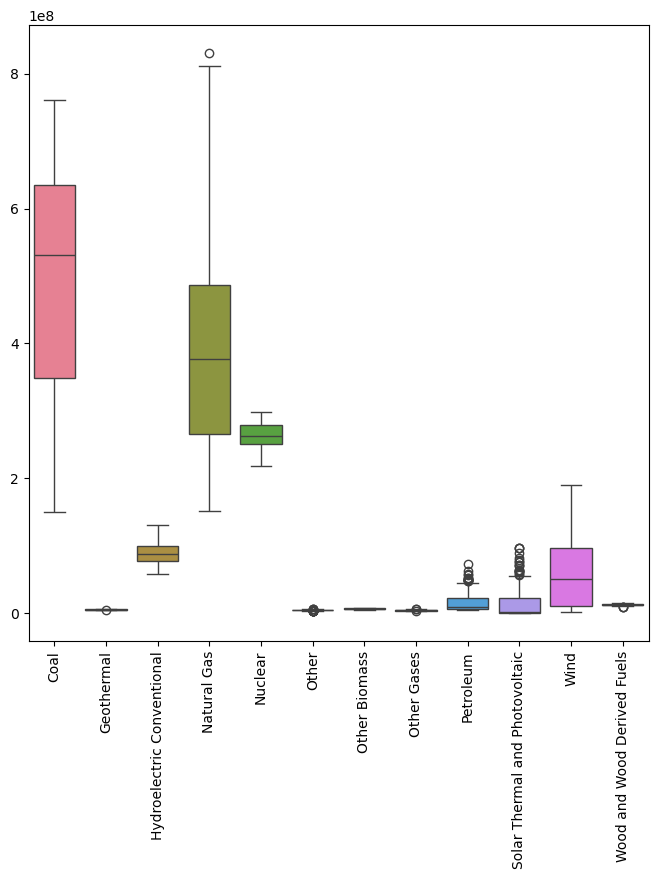

In [21]:
import matplotlib.pyplot as plt 
import seaborn as sns

plt.figure(figsize=(8,8))
sns.boxplot(data=df_series)
plt.xticks(rotation=90)
plt.show()

A pesar de haber algunos puntos marcados como Outliers, están dentro de los rangos de generación normales y no parecen ser errores.

Por tanto, no haremos nada con estos valorees extremos.

Con esto, finalziaremos el apartado de limpieza y pasamos al EDA, guadaremos el dataframe para utilizarlo en el siugiente notebook

In [23]:
df_series.to_csv("../data/cleandf.csv")